# 吴恩达深度学习课程作业L2W7

* TensorFlow入门
* 使用TensorFlow构建dnn网络

## HW参考

1. [视频链接](https://mooc.study.163.com/university/deeplearning_ai#/c)
2. [作业链接](https://github.com/suqi/deeplearning_andrewng/tree/master/Course2-DL-tuning/week7)
3. [tensorflow2指南](https://www.tensorflow.org/guide)


## TensorFlow基础知识

### Eager Execution=即刻执行

TensorFlow 的 Eager Execution 是一种命令式编程环境，可立即评估运算，无需构建计算图：运算会返回具体的值，而非构建供稍后运行的计算图

启用 Eager Execution 会改变 TensorFlow 运算的行为方式 - 现在它们会立即评估并将值返回给 Python。tf.Tensor 对象会引用具体值，而非指向计算图中节点的符号句柄。由于无需构建计算图并稍后在会话中运行，可以轻松使用 print() 或调试程序检查结果。评估、输出和检查张量值不会中断计算梯度的流程

#### 设置和用法

在 Tensorflow 2.0 中，默认启用 Eager Execution。以运行 TensorFlow 运算，结果将立即返回

In [1]:
import os
import tensorflow as tf
import cProfile

2021-10-09 19:51:50.036372: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
tf.executing_eagerly()

True

In [3]:
x = [[2.]]
m = tf.matmul(x, x)
print('hello, {}'.format(m))

2021-10-09 19:54:29.773832: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-09 19:54:29.776461: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-09 19:54:29.949713: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:06:00.0 name: Tesla P40 computeCapability: 6.1
coreClock: 1.531GHz coreCount: 30 deviceMemorySize: 22.38GiB deviceMemoryBandwidth: 323.21GiB/s
2021-10-09 19:54:29.949767: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-09 19:54:29.954709: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-09 19:54:29.954795: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-09 

hello, [[4.]]


Eager Execution 可以很好地配合 NumPy 使用。NumPy 运算接受 tf.Tensor 参数。TensorFlow tf.math 运算会将 Python 对象和 NumPy 数组转换为 tf.Tensor 对象。tf.Tensor.numpy 方法会以 NumPy ndarray 的形式返回该对象的值

In [4]:
a = tf.constant([[1,2], [3,4]])
print(a)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [5]:
b = tf.add(a, 1)
print(b)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


In [6]:
print(a*b)

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [8]:
import numpy as np

c = np.multiply(a, b)
print(c)

[[ 2  6]
 [12 20]]


In [9]:
print(a.numpy())

[[1 2]
 [3 4]]


#### 动态控制流

Eager Execution 的一个主要优势是，在执行模型时，主机语言的所有功能均可用。因此，编写 fizzbuzz 之类的代码会很容易

In [10]:
def fizzbuzz(max_num):
    counter = tf.constant(0)
    max_num = tf.convert_to_tensor(max_num)
    for num in range(1, max_num.numpy()+1):
        num = tf.constant(num)
        if int(num % 3) == 0 and int(num % 5) == 0:
            print('FizzBuzz')
        elif int(num % 3) == 0:
            print('Fizz')
        elif int(num % 5) == 0:
            print('Buzz')
        else:
            print(num.numpy())
        counter += 1

In [11]:
fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


#### Eager训练

##### 计算梯度

自动微分对实现机器学习算法（例如用于训练神经网络的反向传播）十分有用。在 Eager Execution 期间，请使用 tf.GradientTape 跟踪运算以便稍后计算梯度。

您可以在 Eager Execution 中使用 tf.GradientTape 来训练和/或计算梯度。这对复杂的训练循环特别有用。

由于在每次调用期间都可能进行不同运算，所有前向传递的运算都会记录到“条带”中。要计算梯度，请反向播放条带，然后丢弃。特定 tf.GradientTape 只能计算一个梯度；后续调用会引发运行时错误

In [13]:
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:  # 跟踪运算以便稍后计算梯度
    loss = w * w
grad = tape.gradient(loss, w)
print(grad)

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


##### 训练模型

以下示例创建了一个多层模型，该模型会对标准 MNIST 手写数字进行分类。示例演示了在 Eager Execution 环境中构建可训练计算图的优化器和层 API

In [21]:
# Fetch and format the mnist data
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices((tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32), tf.cast(mnist_labels,tf.int64)))  # 归一化并创建数据流
dataset = dataset.shuffle(1000).batch(32)  # shuffle and batch

In [22]:
# build the model
mnist_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, [3,3], activation='relu', input_shape=(None, None, 1)),
    tf.keras.layers.Conv2D(16, [3,3], activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10)
])

# 即使没有训练，也可以在 Eager Execution 中调用模型并检查输出
for images, labels in dataset.take(1):
    print('logits: ', mnist_model(images[0:1]).numpy())

logits:  [[-0.05472895  0.16269219  0.09026919  0.11115909 -0.00300851  0.11862857
   0.05138586 -0.08186927  0.00709331 -0.0081394 ]]


虽然 Keras 模型有内置训练循环（使用 fit 方法），但有时您需要进行更多自定义。下面是一个使用 Eager Execution 实现训练循环的示例

epoch 0 finished.
epoch 1 finished.
epoch 2 finished.


Text(0, 0.5, 'loss [entropy]')

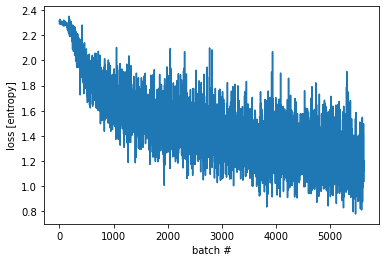

In [23]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_history = []

# 注：请在 tf.debugging 中使用断言函数检查条件是否成立。这在 Eager Execution 和计算图执行中均有效
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = mnist_model(images, training=True)
        tf.debugging.assert_equal(logits.shape, (32, 10))
        loss_value = loss_object(labels, logits)
    
    loss_history.append(loss_value.numpy().mean())
    grads = tape.gradient(loss_value, mnist_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))


def train(epochs):
    for epoch in range(epochs):
        for (batch, (images, labels)) in enumerate(dataset):
            train_step(images, labels)
        print('epoch {} finished.'.format(epoch))


train(3)

import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('batch #')
plt.ylabel('loss [entropy]')

##### 变量和优化器

tf.Variable 对象会存储在训练期间访问的可变、类似于 tf.Tensor 的值，以更简单地实现自动微分。

变量的集合及其运算方法可以封装到层或模型中。有关详细信息，请参阅自定义 Keras 层和模型。层和模型之间的主要区别在于模型添加了如下方法：Model.fit、Model.evaluate 和 Model.save。

例如，上面的自动微分示例可以改写为

In [24]:
class Linear(tf.keras.Model):
    def __init__(self):
        super(Linear, self).__init__()
        self.W = tf.Variable(5., name='weight')
        self.B = tf.Variable(10., name='bias')
    
    def call(self, inputs):
        return self.W * inputs + self.B

# a toy dataset of points around 3*x + 2
num_examples = 2000
training_inputs = tf.random.normal([num_examples])
print(training_inputs.shape)
noise = tf.random.normal([num_examples])
training_outputs = training_inputs * 3 + 2 + noise

# the loss function to be optimized
def loss(model, inputs, targets):
    error = model(inputs) - targets
    return tf.reduce_mean(tf.square(error))

# grad
def grad(model, inputs, target):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, target)
    return tape.gradient(loss_value, [model.W, model.B])

# 下一步，
# 创建模型，
# 损失函数对模型参数的导数，
# 基于导数的参数更新
model = Linear()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
print('initial loss: {}'.format(loss(model, training_inputs, training_outputs)))

epochs = 300
for epoch in range(epochs):
    grads = grad(model, training_inputs, training_outputs)
    optimizer.apply_gradients(zip(grads, [model.W, model.B]))
    if epoch % 20 == 0:
        print('loss at epoch {:03d}: {:.3f}'.format(epoch, loss(model, training_inputs, training_outputs)))

# print w and b
print('W = {}, B = {}'.format(model.W.numpy(), model.B.numpy()))

(2000,)
initial loss: 68.43151092529297
loss at epoch 000: 65.803
loss at epoch 020: 30.265
loss at epoch 040: 14.222
loss at epoch 060: 6.976
loss at epoch 080: 3.702
loss at epoch 100: 2.221
loss at epoch 120: 1.551
loss at epoch 140: 1.248
loss at epoch 160: 1.111
loss at epoch 180: 1.049
loss at epoch 200: 1.020
loss at epoch 220: 1.008
loss at epoch 240: 1.002
loss at epoch 260: 0.999
loss at epoch 280: 0.998
W = 3.005833864212036, B = 1.9850844144821167


<font size=5 color=red>注：变量将一直存在，直至删除对 Python 对象的最后一个引用，并删除该变量</font>

##### 基于对象的保存

tf.keras.Model 包括一个方便的 save_weights 方法，您可以通过该方法轻松创建检查点：

In [31]:
save_path = './temp/weights'
model.save_weights(save_path)
status = model.load_weights(save_path)
# status

# 您可以使用 tf.train.Checkpoint 完全控制此过程
x = tf.Variable(10.)
print(x)
checkpoint = tf.train.Checkpoint(x=x)
x.assign(2.)
print(x)
checkpoint_path = './temp/ckpt/'
checkpoint.save(checkpoint_path)
x.assign(11.)  # change the variable after saving
print(x)
# restore values from the checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))
print(x)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=10.0>
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=11.0>
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>


要保存和加载模型，tf.train.Checkpoint 会存储对象的内部状态，而无需隐藏变量。要记录 model、optimizer 和全局步骤的状态，请将它们传递到 tf.train.Checkpoint

In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, [3,3], activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
checkpoint_dir = './temp/model_dir'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint_path = os.path.join(checkpoint_dir, 'ckpt')
root = tf.train.Checkpoint(optimizer=optimizer, model=model)
root.save(checkpoint_path)
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

注：在许多训练循环中，会在调用 tf.train.Checkpoint.restore 后创建变量。这些变量将在创建后立即恢复，并且可以使用断言来确保检查点已完全加载。有关详细信息，请参阅检查点训练指南

##### 面向对象的指标

tf.keras.metrics 会被存储为对象。可以通过将新数据传递给可调用对象来更新指标，并使用 tf.keras.metrics.result 方法检索结果，例如

In [36]:
m = tf.keras.metrics.Mean('loss')  # Computes the (weighted) mean of the given values
m(0)
m(5)
print(m.result())
m([8, 9])
print(m.result())

tf.Tensor(2.5, shape=(), dtype=float32)
tf.Tensor(5.5, shape=(), dtype=float32)


##### 摘要和TensorBoard

[TensorBoard](https://tensorflow.google.cn/tensorboard)是一种可视化工具，用于了解、调试和优化模型训练过程。它使用在执行程序时编写的摘要事件。

您可以在 Eager Execution 中使用 tf.summary 记录变量摘要。例如，要每 100 个训练步骤记录一次 loss 的摘要，请运行以下代码

In [40]:
logdir = './temp/tb/'
writer = tf.summary.create_file_writer(logdir)  # Creates a summary file writer for the given log directory

steps = 1000
with writer.as_default():
    for i in range(steps):
        step = i + 1
        loss = 1 - 0.001 * step
        if step % 100 == 0:
            tf.summary.scalar('loss', loss, step=step)  # Write a scalar summary

In [41]:
!ls ./temp/tb/

events.out.tfevents.1634041761.spare-unknown113697.i.nease.net.4332.1261432.v2
events.out.tfevents.1634041890.spare-unknown113697.i.nease.net.4332.1261440.v2


#### 自动微分高级主题
##### 动态模型
tf.GradientTape 也可以用于动态模型。下面这个回溯线搜索算法示例看起来就像普通的 NumPy 代码，但它的控制流比较复杂，存在梯度且可微分

In [42]:
def line_search_step(fn, init_x, rate=1.0):
    with tf.GradientTape() as tape:
        # Variables are automatically tracked.
        # But to calculate a gradient from a tensor, you must `watch` it.
        tape.watch(init_x)
        value = fn(init_x)
    grad = tape.gradient(value, init_x)
    grad_norm = tf.reduce_sum(grad*grad)
    init_value = value
    while value > init_value - rate * grad_norm:
        x = init_x - rate * grad
        value = fn(x)
        rate /= 2.0
    return x, value

##### 自定义梯度
自定义梯度是重写梯度的一种简单方法。在前向函数中，定义相对于输入、输出或中间结果的梯度。例如，下面是在后向传递中裁剪梯度范数的一种简单方法

自定义梯度通常用来为运算序列提供数值稳定的梯度

In [43]:
@tf.custom_gradient
def clip_gradient_by_norm(x, norm):
    y = tf.identity(x)
    def grad_fn(dresult):
        return [tf.clip_by_norm(dresult, norm), None]
    return y, grad_fn

In [46]:
def log1pexp(x):
    return tf.math.log(1 + tf.exp(x))

def grad_log1pexp(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        value = log1pexp(x)
    return tape.gradient(value, x)

# The gradient computation works fine at x = 0.
print(grad_log1pexp(tf.constant(0.)))

# However, x = 100 fails because of numerical instability.
print(grad_log1pexp(tf.constant(100.)))

# 此时可以自定义梯度计算

tf.Tensor(0.5, shape=(), dtype=float32)
tf.Tensor(nan, shape=(), dtype=float32)


在此例中，log1pexp 函数可以通过自定义梯度进行分析简化。下面的实现重用了在前向传递期间计算的 tf.exp(x) 值，通过消除冗余计算使其变得更加高效

In [47]:
@tf.custom_gradient
def log1pexp(x):
    e = tf.exp(x)
    def grad(dy):
        return dy*(1 - 1 / (1+e))
    return tf.math.log(1+e), grad

def grad_log1pexp(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        value = log1pexp(x)
    return tape.gradient(value, x)

print(grad_log1pexp(tf.constant(0.)))
print(grad_log1pexp(tf.constant(100.)))

tf.Tensor(0.5, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


#### 性能
在 Eager Execution 期间，计算会自动分流到 GPU。如果想控制计算运行的位置，可将其放在 tf.device('/gpu:0') 块（或 CPU 等效块）中

In [48]:
import time

def measure(x, steps):
    # TensorFlow initializes a GPU the first time it's used, exclude from timing.
    tf.matmul(x, x)
    start = time.time()
    for i in range(steps):
        x = tf.matmul(x, x)
    # tf.matmul can return before completing the matrix multiplication
    # (e.g., can return after enqueing the operation on a CUDA stream).
    # The x.numpy() call below will ensure that all enqueued operations
    # have completed (and will also copy the result to host memory,
    # so we're including a little more than just the matmul operation
    # time).
    _ = x.numpy()
    end = time.time()
    return end - start

shape = (1000, 1000)
steps = 200
print("Time to multiply a {} matrix by itself {} times:".format(shape, steps))

# run on cpu:
x_test = tf.random.normal(shape)
with tf.device('/cpu:0'):
    print('cpu cost: {} secs'.format(measure(x_test, steps)))

# run on gpu:
print(tf.config.experimental.list_logical_devices())
print(tf.config.experimental.list_physical_devices())
with tf.device('/gpu:0'):
    print('gpu cost: {} secs'.format(measure(x_test, steps)))

Time to multiply a (1000, 1000) matrix by itself 200 times:
cpu cost: 0.36700987815856934 secs
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
gpu cost: 0.06110048294067383 secs


In [49]:
# 可以将tf.Tensor对象复制到不同设备进行计算
if tf.config.experimental.list_physical_devices('GPU'):
    x = tf.random.normal([10, 10])
    
    x_gpu0 = x.gpu()
    x_cpu = x.cpu()
    
    _ = tf.matmul(x_cpu, x_cpu)
    _ = tf.matmul(x_gpu0, x_gpu0)

Instructions for updating:
Use tf.identity instead.
Instructions for updating:
Use tf.identity instead.


##### 基准

对于计算量繁重的模型（如在 GPU 上训练的 ResNet50），Eager Execution 性能与 tf.function 执行相当。但是对于计算量较小的模型来说，这种性能差距会越来越大，并且在为有大量小运算的模型优化热代码路径方面，其性能还有待提升

#### 使用函数
虽然 Eager Execution 增强了开发和调试的交互性，但 TensorFlow 1.x 样式的计算图执行在分布式训练、性能优化和生产部署方面具有优势。为了弥补这一差距，TensorFlow 2.0 通过 tf.function API 引入了 function。有关详细信息，请参阅 tf.function 指南

### 张量

#### 简介

张量是具有统一类型（称为 dtype）的多维数组。您可以在 tf.dtypes.DType 中查看所有支持的 dtypes。

如果您熟悉 NumPy，就会知道张量与 np.arrays 有一定的相似性。

就像 Python 数值和字符串一样，所有张量都是不可变的：永远无法更新张量的内容，只能创建新的张量

#### 基础知识

In [52]:
# 一个“标量”（或称“0 秩”张量）。标量包含单个值，但没有“轴”
rank_0_tensor = tf.constant(4)
print(rank_0_tensor)

# “向量”（或称“1 秩”张量）就像一个值列表。向量有 1 个轴
rank_1_tensor = tf.constant([2.0, 3.0, 4.0])
print(rank_1_tensor)

# “矩阵”（或称“2 秩”张量）有 2 个轴
rank_2_tensor = tf.constant([[1,2], [3,4], [5,6]], dtype=tf.float16)
print(rank_2_tensor)

# 张量的轴可能更多，下面是一个包含 3 个轴的张量
# There can be an arbitrary number of
# axes (sometimes called "dimensions")
rank_3_tensor = tf.constant([
                            [[0, 1, 2, 3, 4],
                            [5, 6, 7, 8, 9]],
                            [[10, 11, 12, 13, 14],
                            [15, 16, 17, 18, 19]],
                            [[20, 21, 22, 23, 24],
                            [25, 26, 27, 28, 29]],])

print(rank_3_tensor)

tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor([2. 3. 4.], shape=(3,), dtype=float32)
tf.Tensor(
[[1. 2.]
 [3. 4.]
 [5. 6.]], shape=(3, 2), dtype=float16)
tf.Tensor(
[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]]

 [[10 11 12 13 14]
  [15 16 17 18 19]]

 [[20 21 22 23 24]
  [25 26 27 28 29]]], shape=(3, 2, 5), dtype=int32)


张量与numpy数组的转换

In [53]:
print(np.array(rank_2_tensor))
print(rank_2_tensor.numpy())

[[1. 2.]
 [3. 4.]
 [5. 6.]]
[[1. 2.]
 [3. 4.]
 [5. 6.]]


张量通常包含浮点型和整数数据，但是还有许多其他数据类型，包括：
* 复杂的数值
* 字符串
tf.Tensor基类要求张量是“矩形”--也就是说，每一个轴上的每一个元素大小相同。但是，张量可以处理不同形状的特殊类型。
* 不规则张量([参阅下文中的 RaggedTensor](https://www.tensorflow.org/guide/tensor#ragged_tensors))
* 稀疏张量([参阅下文中的 SparseTensor](https://www.tensorflow.org/guide/tensor#sparse_tensors))

张量的数学运算

In [57]:
a = tf.constant([[1,2], [3,4]])
b = tf.constant([[1,1], [1,1]])

print(tf.add(a, b), '\n')
print(tf.multiply(a, b), '\n')
print(tf.matmul(a, b), '\n')

print(a + b, '\n')
print(a * b, '\n')
print(a @ b, '\n')

c = tf.constant([[4.0, 5.0], [10.0, 1.0]])

print('find the largest value: ', tf.reduce_max(c), '\n')
print('find the index of largest value: ', tf.argmax(c), '\n')
print('compute softmax: ', tf.nn.softmax(c), '\n')

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32) 

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32) 

tf.Tensor(
[[3 3]
 [7 7]], shape=(2, 2), dtype=int32) 

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32) 

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32) 

tf.Tensor(
[[3 3]
 [7 7]], shape=(2, 2), dtype=int32) 

find the largest value:  tf.Tensor(10.0, shape=(), dtype=float32) 

find the index of largest value:  tf.Tensor([1 0], shape=(2,), dtype=int64) 

compute softmax:  tf.Tensor(
[[2.6894143e-01 7.3105854e-01]
 [9.9987662e-01 1.2339458e-04]], shape=(2, 2), dtype=float32) 



#### 形状简介

张量有形状，下面是几个相关术语：
* 形状：张量每个轴的长度
* 秩：张量轴数，标量的秩为0，向量为1，矩阵为2
* 轴或维度：张量的一个特殊维度
* 大小：张量的总项数，即乘积shape

注：虽然您可能会看到“二维张量”之类的表述，但 2 秩张量通常并不是用来描述二维空间

张量和 tf.TensorShape 对象提供了方便的属性来访问

虽然通常用索引来指代轴，但是您始终要记住每个轴的含义。轴一般按照从全局到局部的顺序进行排序：首先是批次轴，随后是空间维度，最后是每个位置的特征。这样，在内存中，特征向量就会位于连续的区域

In [59]:
rank_4_tensor = tf.zeros([3,2,4,5])
# print(rank_4_tensor)
print('type of every element: ', rank_4_tensor.dtype)
print('number of dimensions: ', rank_4_tensor.ndim)
print('shape of Tensor: ', rank_4_tensor.shape)
print('total number of elements: ', tf.size(rank_4_tensor).numpy())

type of every element:  <dtype: 'float32'>
number of dimensions:  4
shape of Tensor:  (3, 2, 4, 5)
total number of elements:  120


#### 索引

##### 单轴索引
TensorFlow 遵循标准 Python 索引规则（类似于在 Python 中为列表或字符串编制索引）以及 NumPy 索引的基本规则。

* 索引从 0 开始编制
* 负索引表示按倒序编制索引
* 冒号 : 用于切片 start:stop:step

In [62]:
rank_1_tensor = tf.constant([0,1,2,3,5,8,13,21,34])
print(rank_1_tensor.numpy())
print('first: ', rank_1_tensor[0].numpy())
print('second: ', rank_1_tensor[1].numpy())
print('last: ', rank_1_tensor[-1].numpy())

print('everything: ', rank_1_tensor[:].numpy())
print('before 4: ', rank_1_tensor[:4].numpy())
print('from 4 to end: ', rank_1_tensor[4:].numpy())
print('from 2 to 7: ', rank_1_tensor[2:7].numpy())
print('every other item: ', rank_1_tensor[::2].numpy())
print('reversed: ', rank_1_tensor[::-1].numpy())

[ 0  1  2  3  5  8 13 21 34]
first:  0
second:  1
last:  34
everything:  [ 0  1  2  3  5  8 13 21 34]
before 4:  [0 1 2 3]
from 4 to end:  [ 5  8 13 21 34]
from 2 to 7:  [ 2  3  5  8 13]
every other item:  [ 0  2  5 13 34]
reversed:  [34 21 13  8  5  3  2  1  0]


##### 多轴索引

更高秩的张量通过传递多个索引来编制索引

对于高秩张量的每个单独轴，遵循单轴索引原则

In [67]:
print(rank_2_tensor.numpy())
print(rank_2_tensor[1, 1].numpy())
print('second row: ', rank_2_tensor[1, :].numpy())
print('second column: ', rank_2_tensor[:, 1].numpy())
print('last row: ', rank_2_tensor[-1, :].numpy())
print('first item in last column: ', rank_2_tensor[0, -1].numpy())
print('skip the first row: ', rank_2_tensor[1:, :].numpy())

# 3轴张量的索引
print(rank_3_tensor[:, :, 4].numpy())

[[1. 2.]
 [3. 4.]
 [5. 6.]]
4.0
second row:  [3. 4.]
second column:  [2. 4. 6.]
last row:  [5. 6.]
first item in last column:  2.0
skip the first row:  [[3. 4.]
 [5. 6.]]
[[ 4  9]
 [14 19]
 [24 29]]


#### 操作形状

reshape a Tensor

In [71]:
# Shape returns a `TensorShape` object that shows the size on each dimension
var_x = tf.Variable(tf.constant([[1], [2], [3]]))
print(var_x.shape)
print(var_x.shape.as_list())

reshaped = tf.reshape(var_x, [1, 3])
print(reshaped.shape)

# 数据在内存中的布局保持不变，同时使用请求的形状创建一个指向同一数据的新张量。TensorFlow 采用 C 样式的“行优先”内存访问顺序，即最右侧的索引值递增对应于内存中的单步位移
print(rank_3_tensor)

# 如果您展平张量，则可以看到它在内存中的排列顺序
print(tf.reshape(rank_3_tensor, [-1]))

(3, 1)
[3, 1]
(1, 3)
tf.Tensor(
[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]]

 [[10 11 12 13 14]
  [15 16 17 18 19]]

 [[20 21 22 23 24]
  [25 26 27 28 29]]], shape=(3, 2, 5), dtype=int32)
tf.Tensor(
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29], shape=(30,), dtype=int32)


一般来说，tf.reshape 唯一合理的用途是用于合并或拆分相邻轴（或添加/移除 1）。

对于 3x2x5 张量，重构为 (3x2)x5 或 3x(2x5) 都合理，因为切片不会混淆

重构可以处理总元素个数相同的任何新形状，但是如果不遵从轴的顺序，则不会发挥任何作用。

利用 tf.reshape 无法实现轴的交换，要交换轴，您需要使用 tf.transpose

* 一些错误的示例

```python
# Bad examples: don't do this

# You can't reorder axes with reshape.
print(tf.reshape(rank_3_tensor, [2, 3, 5]), "\n") 

# This is a mess
print(tf.reshape(rank_3_tensor, [5, 6]), "\n")

# This doesn't work at all
try:
  tf.reshape(rank_3_tensor, [7, -1])
except Exception as e:
  print(f"{type(e).__name__}: {e}")
```

可能会遇到非完全指定的形状。要么是形状包含 None（轴长度未知），要么是整个形状为 None（张量的秩未知）。

除了 tf.RaggedTensor 外，这种情况只会在 TensorFlow 的符号化计算图构建 API 环境中出现

* tf.function
* Keras函数式API

In [72]:
print(tf.reshape(rank_3_tensor, [3*2, 5]))
print(tf.reshape(rank_3_tensor, [3, -1]))

tf.Tensor(
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]
 [25 26 27 28 29]], shape=(6, 5), dtype=int32)
tf.Tensor(
[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]], shape=(3, 10), dtype=int32)


#### DTypes详解

使用 Tensor.dtype 属性可以检查 tf.Tensor 的数据类型。

从 Python 对象创建 tf.Tensor 时，您可以选择指定数据类型。

如果不指定，TensorFlow 会选择一个可以表示您的数据的数据类型。TensorFlow 将 Python 整数转换为 tf.int32，将 Python 浮点数转换为 tf.float32。另外，当转换为数组时，TensorFlow 会采用与 NumPy 相同的规则。

数据类型可以相互转换

In [73]:
the_f64_tensor = tf.constant([2.2, 3.3, 4.4], dtype=tf.float64)
the_f16_tensor = tf.cast(the_f64_tensor, dtype=tf.float16)
# Now, let's cast to an uint8 and lose the decimal precision
the_u8_tensor = tf.cast(the_f16_tensor, dtype=tf.uint8)
print(the_u8_tensor)

tf.Tensor([2 3 4], shape=(3,), dtype=uint8)


#### 广播

广播是从 NumPy 中的等效功能借用的一个概念。简而言之，在一定条件下，对一组张量执行组合运算时，为了适应大张量，会对小张量进行“扩展”。

最简单和最常见的例子是尝试将张量与标量相乘或相加。在这种情况下会对标量进行广播，使其变成与其他参数相同的形状

In [74]:
x = tf.constant([1,2,3])
y = tf.constant(2)
z = tf.constant([2,2,2])
# All of these are the same computation
print(tf.multiply(x, 2))
print(x*y)
print(x*z)

tf.Tensor([2 4 6], shape=(3,), dtype=int32)
tf.Tensor([2 4 6], shape=(3,), dtype=int32)
tf.Tensor([2 4 6], shape=(3,), dtype=int32)


同样，可以扩展长度为 1 的轴，使其匹配其他参数。在同一个计算中可以同时扩展两个参数。

在本例中，一个 3x1 的矩阵与一个 1x4 进行元素级乘法运算，从而产生一个 3x4 的矩阵。注意前导 1 是可选的：y 的形状是 [4]

In [78]:
# these are the same computations
x = tf.reshape(x, [3, 1])
y = tf.range(1, 5)
print(x)
print(y)
print(tf.multiply(x, y))  # 广播相加：[3, 1] 乘以 [1, 4] 的结果是 [3,4]

# 下面是不使用广播的同一运算

x_stretch = tf.constant([[1, 1, 1, 1],
                         [2, 2, 2, 2],
                         [3, 3, 3, 3]])

y_stretch = tf.constant([[1, 2, 3, 4],
                         [1, 2, 3, 4],
                         [1, 2, 3, 4]])

print(x_stretch * y_stretch)  # Again, operator overloading

tf.Tensor(
[[1]
 [2]
 [3]], shape=(3, 1), dtype=int32)
tf.Tensor([1 2 3 4], shape=(4,), dtype=int32)
tf.Tensor(
[[ 1  2  3  4]
 [ 2  4  6  8]
 [ 3  6  9 12]], shape=(3, 4), dtype=int32)
tf.Tensor(
[[ 1  2  3  4]
 [ 2  4  6  8]
 [ 3  6  9 12]], shape=(3, 4), dtype=int32)


在大多数情况下，广播的时间和空间效率更高，因为广播运算不会在内存中具体化扩展的张量。

使用 tf.broadcast_to 可以了解广播的运算方式

与数学运算不同，broadcast_to 并不会节省内存。在这个示例中，您将具体化张量。

这可能会变得更复杂。Jake VanderPlas 的《Python 数据科学手册》一书中的这一节介绍了更多广播技巧（同样使用 NumPy）

In [80]:
print(tf.broadcast_to(tf.constant([1,2,3]), [3,3]))

tf.Tensor(
[[1 2 3]
 [1 2 3]
 [1 2 3]], shape=(3, 3), dtype=int32)


#### tf.convert_to_tensor

大部分运算（如 tf.matmul 和 tf.reshape）会使用 tf.Tensor 类的参数。不过，在上面的示例中，您会发现形状类似于张量的 Python 对象也可以接受。

大部分（但并非全部）运算会在非张量参数上调用 convert_to_tensor。我们提供了一个转换注册表，大多数对象类（如 NumPy 的 ndarray、TensorShape、Python 列表和 tf.Variable）都可以自动转换。

有关更多详细信息，请参阅 tf.register_tensor_conversion_function。如果您有自己的类型，则可能希望自动转换为张量

#### 不规则张量

如果张量的某个轴上的元素个数可变，则称为“不规则”张量。对于不规则数据，请使用 tf.ragged.RaggedTensor。

例如，下面的例子无法用规则张量表示

In [83]:
ragged_list = [
    [0, 1, 2, 3],
    [4, 5],
    [6, 7, 8],
    [9]
]

try:
    tensor = tf.constant(ragged_list)
except Exception as e:
    print(f"{type(e).__name__}: {e}")
    
ragged_tensor = tf.ragged.constant(ragged_list)
print(ragged_tensor)
print(ragged_tensor.shape)

ValueError: Can't convert non-rectangular Python sequence to Tensor.
<tf.RaggedTensor [[0, 1, 2, 3], [4, 5], [6, 7, 8], [9]]>
(4, None)


#### 字符串张量

tf.string 是一种 dtype，也就是说，在张量中，您可以用字符串（可变长度字节数组）来表示数据。

字符串是原子类型，无法像 Python 字符串一样编制索引。字符串的长度并不是张量的一个轴。有关操作字符串的函数，请参阅 tf.strings。

下面是一个标量字符串张量：

In [85]:
# Tensors can be strings, too here is a scalar string
scalar_string_tensor = tf.constant('Gray wolf')
print(scalar_string_tensor)

# If we have three string tensors of different lengths, this is OK.
tensor_of_strings = tf.constant(["Gray wolf",
                                 "Quick brown fox",
                                 "Lazy dog"])
print(tensor_of_strings)

tf.Tensor(b'Gray wolf', shape=(), dtype=string)
tf.Tensor([b'Gray wolf' b'Quick brown fox' b'Lazy dog'], shape=(3,), dtype=string)


在上面的打印输出中，b 前缀表示 tf.string dtype 不是 Unicode 字符串，而是字节字符串。有关在 TensorFlow 如何使用 Unicode 文本的详细信息，请参阅 Unicode 教程。

如果传递 Unicode 字符，则会使用 utf-8 编码

In [86]:
tf.constant("🥳👍")

<tf.Tensor: shape=(), dtype=string, numpy=b'\xf0\x9f\xa5\xb3\xf0\x9f\x91\x8d'>

In [88]:
print(tf.strings.split(scalar_string_tensor, sep=' '))

# ...but it turns into a `RaggedTensor` if we split up a tensor of strings,
# as each string might be split into a different number of parts.
print(tf.strings.split(tensor_of_strings, sep=' '))

tf.Tensor([b'Gray' b'wolf'], shape=(2,), dtype=string)
<tf.RaggedTensor [[b'Gray', b'wolf'], [b'Quick', b'brown', b'fox'], [b'Lazy', b'dog']]>


tf.strings.to_number

虽然不能使用 tf.cast 将字符串张量转换为数值，但是可以先将其转换为字节，然后转换为数值

In [93]:
text = tf.constant('1 10 100')
print(tf.strings.to_number(tf.strings.split(text)))

byte_strings = tf.strings.bytes_split(tf.constant("Duck"))
byte_ints = tf.io.decode_raw(tf.constant('Duck'), tf.uint8)
print(byte_strings)
print(byte_ints)

# Or split it up as unicode and then decode it
unicode_bytes = tf.constant("アヒル 🦆")
unicode_char_bytes = tf.strings.unicode_split(unicode_bytes, "UTF-8")
unicode_values = tf.strings.unicode_decode(unicode_bytes, "UTF-8")

print("\nUnicode bytes:", unicode_bytes)
print("\nUnicode chars:", unicode_char_bytes)
print("\nUnicode values:", unicode_values)

# tf.string dtype 可用于 TensorFlow 中的所有原始字节数据。
# tf.io 模块包含在数据与字节类型之间进行相互转换的函数，包括解码图像和解析 csv 的函数

tf.Tensor([  1.  10. 100.], shape=(3,), dtype=float32)
tf.Tensor([b'D' b'u' b'c' b'k'], shape=(4,), dtype=string)
tf.Tensor([ 68 117  99 107], shape=(4,), dtype=uint8)

Unicode bytes: tf.Tensor(b'\xe3\x82\xa2\xe3\x83\x92\xe3\x83\xab \xf0\x9f\xa6\x86', shape=(), dtype=string)

Unicode chars: tf.Tensor([b'\xe3\x82\xa2' b'\xe3\x83\x92' b'\xe3\x83\xab' b' ' b'\xf0\x9f\xa6\x86'], shape=(5,), dtype=string)

Unicode values: tf.Tensor([ 12450  12498  12523     32 129414], shape=(5,), dtype=int32)


#### 稀疏张量

在某些情况下，数据很稀疏，比如说在一个非常宽的嵌入空间中。为了高效存储稀疏数据，TensorFlow 支持 tf.sparse.SparseTensor 和相关运算

In [94]:
sparse_tensor = tf.sparse.SparseTensor(indices=[[0, 0], [1, 2]], values=[1,2], dense_shape=[3, 4])
print(sparse_tensor)

# convert sparse tensor to dense
print(tf.sparse.to_dense(sparse_tensor))

SparseTensor(indices=tf.Tensor(
[[0 0]
 [1 2]], shape=(2, 2), dtype=int64), values=tf.Tensor([1 2], shape=(2,), dtype=int32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))
tf.Tensor(
[[1 0 0 0]
 [0 0 2 0]
 [0 0 0 0]], shape=(3, 4), dtype=int32)


### 变量

#### 简介

TensorFlow 变量是用于表示程序处理的共享持久状态的推荐方法。本指南介绍在 TensorFlow 中如何创建、更新和管理 tf.Variable 的实例。

变量通过 tf.Variable 类进行创建和跟踪。tf.Variable 表示张量，对它执行运算可以改变其值。利用特定运算可以读取和修改此张量的值。更高级的库（如 tf.keras）使用 tf.Variable 来存储模型参数

#### 设置

本笔记本讨论变量布局。如果要查看变量位于哪一个设备上，请取消注释这一行代码

In [95]:
# Uncomment to see where your variables get placed (see below)
tf.debugging.set_log_device_placement(True)

#### 创建变量

要创建变量，请提供一个初始值。tf.Variable 与初始值的 dtype 相同

变量与张量的定义方式和操作行为都十分相似，实际上，它们都是 tf.Tensor 支持的一种数据结构。与张量类似，变量也有 dtype 和形状，并且可以导出至 NumPy

大部分张量运算在变量上也可以按预期运行，不过变量==无法重构形状==

变量由张量提供支持。您可以使用 tf.Variable.assign 重新分配张量。调用 assign（通常）不会分配新张量，而会重用现有张量的内存

如果在运算中像使用张量一样使用变量，那么通常会对支持张量执行运算。

从现有变量创建新变量会复制支持张量。两个变量不能共享同一内存空间


In [109]:
my_tensor = tf.constant([[1.0,2.0], [3.0,4.0]])
my_variable = tf.Variable(my_tensor)

# variable can be all kinds of types ,just like tensors
bool_variable = tf.Variable([False, False, False, True])
complex_variable = tf.Variable([5+4j, 6+1j])
print(complex_variable)
print(complex_variable.shape)
print(complex_variable.dtype)
print(complex_variable.numpy)

print(my_variable)
print(tf.convert_to_tensor(my_variable))
print(tf.argmax(my_variable))
# This creates a new tensor; it does not reshape the variable.
print("\nCopying and reshaping: ", tf.reshape(my_variable, ([1,4])))
print(my_variable)

a = tf.Variable([2.0, 3.0])
a.assign([1, 2])
# Not allowed as it resizes the variable: 
try:
    a.assign([1.0, 2.0, 3.0])
except Exception as e:
    print(f"{type(e).__name__}: {e}")

a = tf.Variable([2.0,3.0])
# Create b based on the value of a
b = tf.Variable(a)
a.assign([5,6])

# a and b are different
print(a.numpy())
print(b.numpy())

# There are other versions of assign
print(a.assign_add([2,3]).numpy())
print(a.assign_sub([7,9]).numpy())

<tf.Variable 'Variable:0' shape=(2,) dtype=complex128, numpy=array([5.+4.j, 6.+1.j])>
(2,)
<dtype: 'complex128'>
<bound method BaseResourceVariable.numpy of <tf.Variable 'Variable:0' shape=(2,) dtype=complex128, numpy=array([5.+4.j, 6.+1.j])>>
<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[1., 2.],
       [3., 4.]], dtype=float32)>
tf.Tensor(
[[1. 2.]
 [3. 4.]], shape=(2, 2), dtype=float32)
tf.Tensor([1 1], shape=(2,), dtype=int64)

Copying and reshaping:  tf.Tensor([[1. 2. 3. 4.]], shape=(1, 4), dtype=float32)
<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[1., 2.],
       [3., 4.]], dtype=float32)>
ValueError: Cannot assign to variable Variable:0 due to variable shape (2,) and value shape (3,) are incompatible
[5. 6.]
[2. 3.]
[7. 9.]
[0. 0.]


#### 生命周期、命名和监视

在基于 Python 的 TensorFlow 中，tf.Variable 实例与其他 Python 对象的生命周期相同。如果没有对变量的引用，则会自动将其解除分配。

为了便于跟踪和调试，您还可以为变量命名。两个变量可以使用相同的名称

保存和加载模型时会保留变量名。默认情况下，模型中的变量会自动获得唯一变量名，所以除非您希望自行命名，否则不必多此一举。

虽然变量对微分很重要，但某些变量不需要进行微分。在创建时，通过将 trainable 设置为 False 可以关闭梯度。例如，训练计步器就是一个不需要梯度的变量

In [113]:
# Create a and b; they have the same value but are backed by different tensors.
a = tf.Variable(my_tensor, name='Mark')
# A new variable with the same name, but different value
# Note that the scalar add is broadcast
b = tf.Variable(my_tensor+1, name='Mark')

# These are elementwise-unequal, despite having the same name
print(a == b)

step_counter = tf.Variable(1, trainable=False)
print(step_counter)

tf.Tensor(
[[False False]
 [False False]], shape=(2, 2), dtype=bool)
<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=1>


#### 放置变量和张量

为了提高性能，TensorFlow 会尝试将张量和变量放在与其 dtype 兼容的最快设备上。这意味着如果有 GPU，那么大部分变量都会放置在 GPU 上。

不过，我们可以重写变量的位置。在以下代码段中，即使存在可用的 GPU，我们也可以将一个浮点张量和一个变量放置在 CPU 上。通过打开设备分配日志记录（参阅设置），可以查看变量的所在位置。

注：虽然可以手动放置变量，但使用分布策略是一种可优化计算的更便捷且可扩展的方式。

如果在有 GPU 和没有 GPU 的不同后端上运行此笔记本，则会看到不同的记录。请注意，必须在会话开始时打开设备布局记录。

可以将变量或张量的位置设置在一个设备上，然后在另一个设备上执行计算。但这样会产生延迟，因为需要在两个设备之间复制数据。

不过，如果您有多个 GPU 工作进程，但希望变量只有一个副本，则可以这样做

注：由于 tf.config.set_soft_device_placement 默认处于打开状态，所以，即使在没有 GPU 的设备上运行此代码，它也会运行，只不过乘法步骤在 CPU 上执行

In [122]:
tf.config.set_soft_device_placement(True)
print(tf.config.experimental.list_physical_devices())
with tf.device('GPU:0'):
    # create some tensors
    a = tf.Variable([[1.0,2.0,3.0], [4.0,5.0,6.0]])
    b = tf.constant([[1.0,2.0], [3.0,4.0], [5.0,6.0]])
    c = tf.matmul(a, b)
print(c)

with tf.device('CPU:0'):
    a = tf.Variable([[1.0,2.0,3.0], [4.0,5.0,6.0]])
    b = tf.constant([[1.0,2.0,3.0]])
with tf.device('GPU:0'):
    k = a*b
print(k)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 1.  4.  9.]
 [ 4. 10. 18.]], shape=(2, 3), dtype=float32)


### 自动微分

#### 自动微分和梯度

自动微分对于实现机器学习算法（例如，用于训练神经网络的反向传播）非常有用。

在本指南中，您将探索使用 TensorFlow 计算梯度的方法，尤其是在 Eager Execution 中

#### 计算梯度

要实现自动微分，TensorFlow 需要记住在前向传递过程中哪些运算以何种顺序发生。随后，在后向传递期间，TensorFlow 以相反的顺序遍历此运算列表来计算梯度

#### 梯度带

TensorFlow 为自动微分提供了 tf.GradientTape API；即计算某个计算相对于某些输入（通常是 tf.Variable）的梯度。TensorFlow 会将在 tf.GradientTape 上下文内执行的相关运算“记录”到“条带”上。TensorFlow 随后会该使用条带通过反向模式微分计算“记录的”计算的梯度

记录一些运算后，使用 GradientTape.gradient(target, sources) 计算某个目标（通常是损失）相对于某个源（通常是模型变量）的梯度

In [126]:
x = tf.Variable(3.0)

with tf.GradientTape() as tape:
    y = x**2

# dy = 2x * dx
dy_dx = tape.gradient(y, x)
print(dy_dx.numpy())

# 上方示例使用标量，但是 tf.GradientTape 在任何张量上都可以轻松运行
w = tf.Variable(tf.random.normal((3,2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1.,2.,3.]]
with tf.GradientTape(persistent=True) as tape:
    y = x @ w + b
    loss = tf.reduce_mean(y**2)
[dl_dw, dl_db] = tape.gradient(loss, [w, b])
print(dl_dw.numpy())
print(dl_db.numpy())

# 要获得 loss 相对于两个变量的梯度，可以将这两个变量同时作为 gradient 方法的源传递。
# 梯度带在关于源的传递方式上非常灵活，可以接受列表或字典的任何嵌套组合，
# 并以相同的方式返回梯度结构（请参阅 tf.nest）
my_vars = {
    'w': w,
    'b': b
}
grad = tape.gradient(loss, my_vars)
print(grad)

6.0
[[ 4.689597  4.537785]
 [ 9.379194  9.07557 ]
 [14.068791 13.613356]]
[4.689597 4.537785]
{'w': <tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 4.689597,  4.537785],
       [ 9.379194,  9.07557 ],
       [14.068791, 13.613356]], dtype=float32)>, 'b': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([4.689597, 4.537785], dtype=float32)>}


#### 相对于模型的梯度

通常将 tf.Variables 收集到 tf.Module 或其子类之一（layers.Layer、keras.Model）中，用于设置检查点和导出。

在大多数情况下，需要计算相对于模型的可训练变量的梯度。 由于 tf.Module 的所有子类都在 Module.trainable_variables 属性中聚合其变量，您可以用几行代码计算这些梯度

In [127]:
layer = tf.keras.layers.Dense(2, activation='relu')
x = tf.constant([[1.,2.,3.]])

with tf.GradientTape() as tape:
    # forward pass
    y = layer(x)
    loss = tf.reduce_mean(y**2)

# Calculate gradients with respect to every trainable variable
grad = tape.gradient(loss, layer.trainable_variables)

for var, g in zip(layer.trainable_variables, grad):
    print(f'{var.name}, {g}')

dense_3/kernel:0, [[2.6922834 0.       ]
 [5.384567  0.       ]
 [8.07685   0.       ]]
dense_3/bias:0, [2.6922834 0.       ]


#### 控制梯度带监视的内容

默认行为是在访问可训练 tf.Variable 后记录所有运算。原因如下：

* 条带需要知道在前向传递中记录哪些运算，以计算后向传递中的梯度。
* 梯度带包含对中间输出的引用，因此应避免记录不必要的操作。
* 最常见用例涉及计算损失相对于模型的所有可训练变量的梯度。

以下示例无法计算梯度，因为默认情况下 tf.Tensor 未被“监视”，并且 tf.Variable 不可训练


In [131]:
# A trainable variable
x0 = tf.Variable(3.0, name='x0')
# Not trainable
x1 = tf.Variable(3.0, name='x1', trainable=False)
# Not a Variable: A variable + tensor returns a tensor.
x2 = tf.Variable(2.0, name='x2') + 1.0
# Not a variable
x3 = tf.constant(3.0, name='x3')

with tf.GradientTape() as tape:
    y = (x0**2) + (x1**2) + (x2**2)

grad = tape.gradient(y, [x0, x1, x2, x3])

for g in grad:
    print(g)

# 可以使用 GradientTape.watched_variables 方法列出梯度带正在监视的变量：
print([var.name for var in tape.watched_variables()])

tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None
['x0:0']


tf.GradientTape 提供了钩子，让用户可以控制被监视或不被监视的内容。

要记录相对于 tf.Tensor 的梯度，您需要调用 GradientTape.watch(x)：

In [133]:
x = tf.constant(3.0)
with tf.GradientTape() as tape:
    tape.watch(x)
    y = x**2
# dy=2x*dx
dy_dx = tape.gradient(y, x)
print(dy_dx.numpy())

6.0


相反，要停用监视所有 tf.Variables 的默认行为，请在创建梯度带时设置 watch_accessed_variables=False。此计算使用两个变量，但仅连接其中一个变量的梯度：

In [134]:
x0 = tf.Variable(0.0)
x1 = tf.Variable(10.0)

with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(x1)
    y0 = tf.math.sin(x0)
    y1 = tf.nn.softplus(x1)
    y = y0 + y1
    ys = tf.reduce_sum(y)
grad = tape.gradient(ys, {'x0': x0, 'x1': x1})

print(grad)

{'x0': None, 'x1': <tf.Tensor: shape=(), dtype=float32, numpy=0.9999546>}


#### 中间结果

可以请求输出相对于 tf.GradientTape 上下文中计算的中间值的梯度

In [135]:
x = tf.constant(3.0)
with tf.GradientTape() as tape:
    tape.watch(x)
    y = x * x
    z = y * y
# Use the tape to compute the gradient of z with respect to the
# intermediate value y.
# dz_dy = 2 * y and y = x ** 2 = 9
print(tape.gradient(z, y).numpy())

18.0


默认情况下，只要调用 GradientTape.gradient 方法，就会释放 GradientTape 保存的资源。要在同一计算中计算多个梯度，请创建一个`persistent=True`的梯度带。这样一来，当梯度带对象作为垃圾回收时，随着资源的释放，可以对 gradient 方法进行多次调用。例如

In [137]:
x = tf.constant([1, 3.0])
with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    y = x * x
    z = y * y
print(tape.gradient(z, x).numpy())
print(tape.gradient(y, x).numpy())

del tape  # drop the reference to the tape

[  4. 108.]
[2. 6.]


#### 性能说明

* 在梯度带上下文内进行运算会有一个微小的开销。对于大多数 Eager Execution 来说，这一成本并不明显，但是您仍然应当仅在需要的地方使用梯度带上下文。

* 梯度带使用内存来存储中间结果，包括输入和输出，以便在后向传递中使用。

为了提高效率，某些运算（例如 ReLU）不需要保留中间结果，而是在前向传递中进行剪枝。不过，如果在梯度带上使用 persistent=True，则不会丢弃任何内容，并且峰值内存使用量会更高

#### 非标量目标的梯度

梯度从根本上说是对标量的运算

In [139]:
x = tf.Variable(2.0)
with tf.GradientTape(persistent=True) as tape:
    y0 = x**2
    y1 = 1 / x
print(tape.gradient(y0, x).numpy())
print(tape.gradient(y1, x).numpy())

# 因此，如果需要多个目标的梯度，则每个源的结果为：

# 目标总和的梯度，或等效
# 每个目标的梯度总和。
x = tf.Variable(2.0)
with tf.GradientTape() as tape:
    y0 = x**2
    y1 = 1 / x

print(tape.gradient({'y0': y0, 'y1': y1}, x).numpy())

# 类似地，如果目标不是标量，则计算总和的梯度
x = tf.Variable(2.)

with tf.GradientTape() as tape:
    y = x * [3., 4.]

print(tape.gradient(y, x).numpy())

4.0
-0.25
3.75
7.0


这样一来，就可以轻松获取损失集合总和的梯度，或者逐元素损失计算总和的梯度。

如果每个条目都需要单独的梯度，请参阅雅可比矩阵。

在某些情况下，您可以跳过雅可比矩阵。对于逐元素计算，总和的梯度给出了每个元素相对于其输入元素的导数，因为每个元素都是独立的：

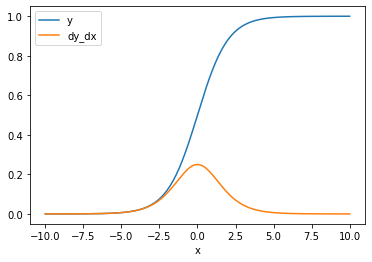

In [140]:
x = tf.linspace(-10.0, 10, 200+1)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.nn.sigmoid(x)
dy_dx = tape.gradient(y, x)

plt.plot(x, y, label='y')
plt.plot(x, dy_dx, label='dy_dx')
plt.legend()
_ = plt.xlabel('x')

#### 控制流

在执行运算时，由于梯度带会记录这些运算，因此会自然地处理 Python 控制流（例如 if 和 while 语句）。

此处，if 的每个分支上使用不同变量。梯度仅连接到使用的变量：

注意，控制语句本身不可微分，因此对基于梯度的优化器不可见。


In [144]:
x = tf.constant(1.0)
v0 = tf.Variable(2.0)
v1 = tf.Variable(2.0)

with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    if x > 0.0:
        result = v0
    else:
        result = v1**2
dv0, dv1 = tape.gradient(result, [v0, v1])

print(dv0)
print(dv1)  # 此处由于x=1.0>0.0，所以dv1的梯度没被连接，所以是None

# 根据上面示例中 x 的值，梯度带将记录 result = v0 或 result = v1**2。 相对于 x 的梯度始终为 None
dx = tape.gradient(result, x)
print(dx)

tf.Tensor(1.0, shape=(), dtype=float32)
None
None


#### 获取None的梯度

当目标未连接到源时，您将获得 None 的梯度

In [146]:
x = tf.Variable(2.)
y = tf.Variable(3.)
with tf.GradientTape() as tape:
    z = y * y
print(tape.gradient(z, x))

None


此处 z 显然未连接到 x，但可以通过几种不太明显的方式将梯度断开

1. 使用张量替换变量

在控制梯度带监视内容部分中，梯度带会自动监视 tf.Variable，但不会监视 tf.Tensor。

一个常见错误是无意中将 tf.Variable 替换为 tf.Tensor，而不使用 Variable.assign 更新 tf.Variable。见下例

2. 在 TensorFlow 之外进行了计算
如果计算退出 TensorFlow，梯度带将无法记录梯度路径。例如

3. 通过整数或字符串获取梯度
整数和字符串不可微分。如果计算路径使用这些数据类型，则不会出现梯度。

谁也不会期望字符串是可微分的，但是如果不指定 dtype，很容易意外创建一个 int 常量或变量

4. 通过有状态对象获取梯度
状态会停止梯度。从有状态对象读取时，梯度带只能观察当前状态，而不能观察导致该状态的历史记录。

tf.Tensor 不可变。张量创建后就不能更改。它有一个值，但没有状态。目前讨论的所有运算也都无状态：tf.matmul 的输出只取决于它的输入。

tf.Variable 具有内部状态，即它的值。使用变量时，会读取状态。计算相对于变量的梯度是正常操作，但是变量的状态会阻止梯度计算进一步向后移动。 例如

类似地，tf.data.Dataset 迭代器和 tf.queue 也有状态，会停止经过它们的张量上的所有梯度

In [154]:
# 1
x = tf.Variable(2.0)

for epoch in range(2):
    with tf.GradientTape() as tape:
        y = x + 1
    print(type(x).__name__, ':', tape.gradient(y, x))
    x = x + 1  # this should be 'x.assign_add(1)',不然会将其转为tensor，而计算不了梯度

# 2
x = tf.Variable([[1., 2.],
                 [3., 4.]], dtype=tf.float32)
with tf.GradientTape() as tape:
    x2 = x**2
    
    # this step is calculated with numpy,即退出了tensorflow计算
    y = np.mean(x2, axis=0)
    
    # Like most ops, reduce_mean will cast the NumPy array to a constant tensor
    # using `tf.convert_to_tensor`.
    y = tf.reduce_mean(y, axis=0)
print(tape.gradient(y, x))

# 3
x = tf.constant(10)
with tf.GradientTape() as tape:
    tape.watch(x)
    y = x * x
print(tape.gradient(y, x))

# 4
x0 = tf.Variable(3.0)
x1 = tf.Variable(1.0)

with tf.GradientTape(persistent=True) as tape:
    # update x1 = x1 + x0
    x1.assign_add(x0)
    # the tape starts recording from x1
    y = x1 ** 2  # y = (x1+x0)**2
# this doesn't work
print(tape.gradient(y, x0))  # dy/dx0=2*(x1+x0)
print(tape.gradient(y, x1))

ResourceVariable : tf.Tensor(1.0, shape=(), dtype=float32)
EagerTensor : None
None
None
None
tf.Tensor(8.0, shape=(), dtype=float32)


#### 未注册梯度

某些 tf.Operation 被注册为不可微分，将返回 None。还有一些则未注册梯度。

tf.raw_ops 页面显示了哪些低级运算已经注册梯度。

如果您试图通过一个没有注册梯度的浮点运算获取梯度，梯度带将抛出错误，而不是直接返回 None。这样一来，您可以了解某个环节出现问题。

例如，tf.image.adjust_contrast 函数封装了 raw_ops.AdjustContrastv2，此运算可能具有梯度，但未实现该梯度：

如果需要通过此运算进行微分，则需要实现梯度并注册该梯度（使用 tf.RegisterGradient），或者使用其他运算重新实现该函数

In [158]:
image = tf.Variable([[[0.5,0.0,0.0]]])
delta = tf.Variable(0.1)

with tf.GradientTape() as tape:
    new_image = tf.image.adjust_contrast(image, delta)  # Adjust contrast of RGB or grayscale images.

try:
    print(tape.gradient(new_image, [image, delta]))
    assert False  # this should not happen
except Exception as e:
    print(f'{type(e).__name__}: {e}')
    

LookupError: gradient registry has no entry for: AdjustContrastv2


#### 零而不是None

在某些情况下，对于未连接的梯度，得到 0 而不是 None 会比较方便。您可以使用 unconnected_gradients 参数来决定具有未连接的梯度时返回的内容

In [161]:
x = tf.Variable([2., 2.])
y = tf.Variable(3.)

with tf.GradientTape(persistent=True) as tape:
    z = y ** 2
print(tape.gradient(z, x))
print(tape.gradient(z, x, unconnected_gradients=tf.UnconnectedGradients.ZERO))

None
tf.Tensor([0. 0.], shape=(2,), dtype=float32)


### 图和函数简介

#### 概述

This is a big-picture overview that covers how `tf.function` allows you to switch from eager execution to graph execution. For a more complete specification of `tf.function`, go to the `tf.function` guide

#### 什么是 图

Graphs are data structures that contain a set of `tf.Operation` objects, which represent units of computation; and `tf.Tensor` objects, which represent the units of data that flow between operations

![two layer network](./深度学习之吴恩达课程作业6/two-layer-network.png)

* 图的好处

graphs are extremely useful and let your TensorFlow run fast, run in parallel, and run efficiently on multiple devices

#### steup

In [162]:
import tensorflow as tf
import timeit
from datetime import datetime

#### taking advantage of graphs

You create and run a graph in TensorFlow by using tf.function, either as a direct call or as a decorator. tf.function takes a regular function as input and returns a Function. A Function is a Python callable that builds TensorFlow graphs from the Python function. You use a Function in the same way as its Python equivalent.

In [165]:
# define a python function
def a_regular_function(x, y, b):
    x = tf.matmul(x, y)
    x = x + b
    return x

# tensorflow function
a_function_that_uses_a_graph = tf.function(a_regular_function)

# make some tensors.
x1 = tf.constant([[1.0, 2.0]])
y1 = tf.constant([[2.0], [3.0]])
b1 = tf.constant(4.0)

orig_value = a_regular_function(x1, y1, b1).numpy
print(orig_value)
# call a function like a python function
tf_function_value = a_function_that_uses_a_graph(x1, y1, b1).numpy()
print(tf_function_value)
assert(orig_value == tf_function_value)

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[12.]], dtype=float32)>>
[[12.]]


AssertionError: 

On the outside, a Function looks like a regular function you write using TensorFlow operations. Underneath, however, it is very different. A Function encapsulates several tf.Graphs behind one API. That is how Function is able to give you the benefits of graph execution, like speed and deployability.

tf.function applies to a function and all other functions it calls: